# YOLO from scratch

This Jupyter notebook demonstrates the implementation of YOLO (You Only Look Once), a popular real-time object detection model, using PyTorch. YOLO is a one-stage object detection model that directly predicts bounding boxes and class probabilities for objects in an image.

The notebook is structured as follows:

1. **Introduction**: This section provides a brief overview of YOLO and its architecture.
2. **Data**: This section loads the CPPE-5 dataset, which serves as a dataset for medical object detection tasks.
3. **Model**: In this section, we define the YOLO model. The YOLO architecture typically consists of a convolutional neural network backbone followed by detection layers responsible for predicting bounding boxes and class probabilities.
4. **Training**: Here, we train the YOLO model on the CPPE-5 dataset. The training process includes optimizing the model's parameters for object detection.
5. **Evaluation**: The notebook also includes an evaluation section where we assess the performance of the trained YOLO model on the dataset.

To execute the notebook, you should ensure you have PyTorch, the torchvision package, and any required dependencies like albumentations installed. Once your environment is set up, you can initiate the notebook and execute it by clicking the "Run" button in the Jupyter interface.

## Introduction

YOLO (You Only Look Once) is an object detection model known for its real-time performance. Unlike Faster R-CNN, which is a two-stage object detection model, YOLO is a one-stage model. It directly predicts bounding boxes and class probabilities for objects in a single forward pass.

The YOLO model comprises the following key components:

- Backbone network: The backbone network, typically a convolutional neural network (CNN), is responsible for extracting features from the input image. YOLOv5 typically employs CSPDarknet53 as the backbone network.
- Neck network: "Neck" refers to an intermediate network or module that connects the backbone network (which extracts features from the input data) to the detection or classification head (which makes predictions based on those features). The neck network plays a crucial role in feature fusion, dimension reduction, and enhancing the representation of features before feeding them into the head for final predictions. YOLOv5 uses a PANet (Path Aggregation Network) as the neck network. PANet enhances feature aggregation and spatial information flow across different network stages.
- Detection Head: YOLO's detection head is the heart of the model. It is a set of convolutional layers that simultaneously predict bounding boxes, class probabilities, and objectness scores for each grid cell in the feature map. YOLO uses anchor boxes in its Detection Head to improve object detection accuracy. Anchor boxes are predefined bounding box shapes with specific sizes and aspect ratios, which help the model predict the dimensions and positions of objects more accurately and efficiently. We will see it in detail later.
- Non-maximum Suppression: After predictions are made, YOLOv5 uses NMS to eliminate duplicate or highly overlapping bounding boxes, retaining the most confident ones.

Before any trainig or inference on the model, YOLO performs input normalization by dividing the image by 255 to make it in the range of [0,1]. This is the normalization they use in the original [repo](https://github.com/ultralytics/yolov5/), yet if you train from scratch on a big dataset you are freee to choose another method of normalization (mean subtraction and standard deviation division), as long as your datat preprocessing is same in training and inference.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# The following code shows a simplified example of a YOLOv5 model's forward method:

def forward(images):
    normalized = transform.preprocess(images.tensors)
    features, skip_connections = backbone(normalized)
    features_neck, skip_connections_neck = neck(features, skip_connections)
    detections = detection_head(features_neck, skip_connections_neck, anchors_boxes)
    detections = transform.postprocess(detections)

In [2]:
import requests
import numpy as np
from tqdm import tqdm
from pathlib import Path
from typing import Tuple, List, Optional, Union

import torch
from torch import nn
import transformers
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from torchvision.ops import nms, box_convert

import cv2
import albumentations
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt

In [3]:
# Let us first load a ready model and see how it detects
device = "cuda" if torch.cuda.is_available() else "cpu"

torch.hub.set_dir("/archive/turganbay")
model_yolo = torch.hub.load('ultralytics/yolov5', 'custom', 'models/yolov5s', autoshape=True).to(device)
labels = model_yolo.names # save the labels for later use

Using cache found in /archive/turganbay/ultralytics_yolov5_master
YOLOv5 🚀 2023-10-12 Python-3.8.10 torch-2.1.0+cu121 CUDA:0 (Tesla P100-SXM2-16GB, 16276MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


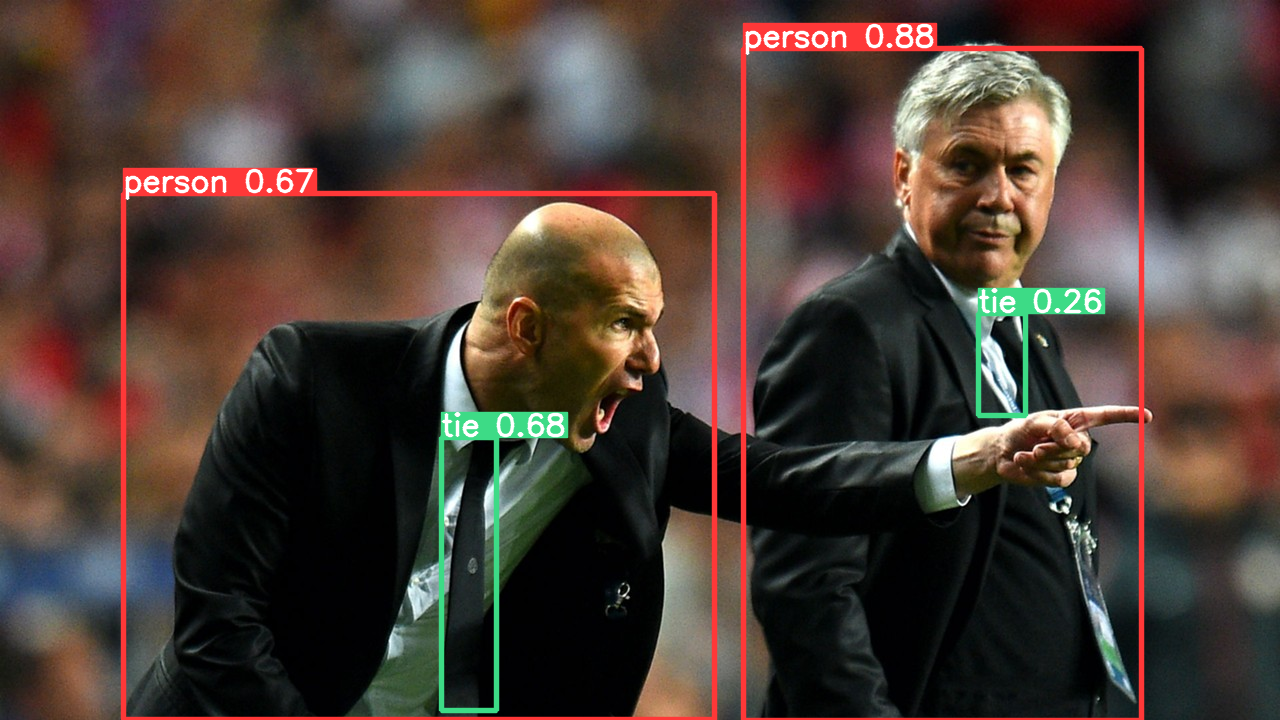

In [5]:
res = model_yolo("https://ultralytics.com/images/zidane.jpg")
res.show()

## Model

Let us start be defining the model components as seperate modules. We will be basing on the architecture schema [picture](https://docs.ultralytics.com/yolov5/tutorials/architecture_description/#1-model-structure) they have in the documentation.

The image shows that the model consista of differen blocks, such as ConvBNSiLU, C3, Bottleneck, SPPF. The left row of the image util SPPF module is the backbone. Then we have neck part and lastly three green boxes in the right side of the image are the heads. It can be noticed that:

- YOLO utilizes skip connections, which are a form of shortcut connections, to enhance the flow of information and improve the accuracy of object detection. Skip connections connect feature maps from different layers of the neural network. They allow YOLO to access both low-level and high-level features, enabling the model to capture fine-grained details and context simultaneously, which is critical for accurate object localization and classification. These skip connections contribute to YOLO's ability to detect objects of different sizes and shapes in complex scenes.

- YOLO uses SiLU as activation instead of the ReLU.

- YOLO uses SPPF (Spatial Pyramid Pooling Fast) to efficiently pool and aggregate features from different regions of the input image. This allows YOLO to extract essential information from various spatial contexts in an image without requiring additional computational resources.

- YOLO neck is designed in the style of PANet (Path Aggregation Network), which enhances information flow between lower and topmost features through route connections, facilitating feature concatenation from different depths of the backbone. Also, features from the neck's initial part are combined (concatenated) with features from the final part of the neck, just before the detection heads.

- YOLOv5, in comparison to the veru first version of the model, employs three detection heads to detect objects at various scales and sizes within an image. Each detection head focuses on objects of specific scales, and together, they cover a broad range of object sizes.

ConvBNSiLU is a simple convolutional module with BatchNorm and activation function.

In [4]:
class ConvBNSiLU(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.SiLU(inplace=True)

    def forward(self, x):
        return self.activation(self.bn(self.conv(x)))

There are two Bottleneck modules. 

Bottleneck 1 is a residual block featuring two skipped connections. If you look at he source code of YOLOv5, it has a width_multiple parameter, often called the expansion factor. This parameter controls the degree to which the channel count between in_channel and out_channel should be compressed and then expanded.

Bottleneck 2 is essentially identical to the first one, with the notable difference that it lacks any skip connections.

In [5]:
class Bottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, expansion=1.0, skip=True):
        super().__init__()
        channel_intermediate = int(expansion*in_channels)
        self.convBlock1 = ConvBNSiLU(in_channels, channel_intermediate, kernel_size=1, stride=1, padding=0)
        self.convBlock2 = ConvBNSiLU(channel_intermediate, out_channels, kernel_size=3, stride=1, padding=1)
        self.skip = skip

    def forward(self, x):
        out = self.convBlock2(self.convBlock1(x))
        if self.skip:
            out += x
        return out

C3 module consists of the convolution modules and variuos bottlenecks. To control the number of sequential repetitions of the Bottleneck blocks, it uses a depth parameter. The Bottlenecks' output and the output from the skipped connection are channel-wise concatenated, and the resulting tensor is subsequently passed through the final convolutional block.

In [6]:
class C3(nn.Module):
    def __init__(self, in_channels, out_channels, number, expansion=0.5, skip=True):
        super().__init__()
        inter = int(in_channels * expansion)
        self.convBlock1 = ConvBNSiLU(in_channels, inter, kernel_size=1, stride=1, padding=0)
        self.convBlock2 = ConvBNSiLU(in_channels, inter, kernel_size=1, stride=1, padding=0)
        self.convBlock3 = ConvBNSiLU(out_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.layers = nn.Sequential(*[Bottleneck(inter, inter, expansion=1.0, skip=skip) for _ in range(number)])
    
    def forward(self, x):
        x1 = self.layers(self.convBlock1(x))
        x2 = self.convBlock2(x)
        concat = torch.cat((x1, x2), dim=1) # concat on channel dimension
        return self.convBlock3(concat)

The SPPF module is employed to leverage its feature re-aggregation capabilities achieved through a series of max pooling and concatenation operations. It comprises three Max Pooling layers and a Convolution Block for the final feature aggregation.

In [7]:
class SPPF(nn.Module):
    def __init__(self, in_channels, number=3):
        super().__init__()
        inter = in_channels // 2
        self.convBlock1 = ConvBNSiLU(in_channels, inter, kernel_size=1, stride=1, padding=0)
        self.maxPool = nn.MaxPool2d(kernel_size=5, stride=1, padding=2)
        self.convBlock2 = ConvBNSiLU(inter * (number+1), in_channels, kernel_size=1, stride=1, padding=0)
        self.number = number
    
    def forward(self, x):
        out = self.convBlock1(x)
        outputs = [out]
        for _ in range(self.number):
            pooled = self.maxPool(out)
            outputs.append(pooled)
            out = pooled
        return self.convBlock2(torch.cat(outputs, dim=1))

The DetectionHead module is a crucial part of an object detection network. It's used for predicting bounding boxes and class probabilities. Its key functions are:

- Anchor Boxes: It handles anchor boxes, which are essential for accurately predicting object locations and scales. So for each detetcion head we use several anchor boxes each resposible for detecting images of different sizes. It could be that one anchors is resposible for squared object boxes, and the other for ractancular shape object boxes.


- Multi-Layer Predictions: It generates predictions at different scales using a series of 1x1 convolutional layers. The self.out_convs consists of three detection heads, where each of them will have as input features from various depths of the neck part as it can be seen from the architecture image. The output of these layers is a tensor with shape (batch_size, (5 + num_classes) * num_anchors, grid_y, grid_x), where the 5 stand for the xc (x-center coordinates), yc (y-center coordinates), width, height and objectness_score for each possible bounding box. Grid_y and grid_x is the size of the grid on the input to the head. Usually there grid dimensions are: 
    - the head 1 is 80 x 80 and is used to detect small objects
    - the head 3 is 40 x 40 and is used to detect medium-sized objects
    - the head 3 is 20 x 20 and is used to detect large objects


- Efficient Grid and Anchor Setup: It sets up grids and anchor grids, facilitating precise bounding box prediction interpretation. As it can be nooted from the make_grids function, the grids are built for each detection head using its anchors and strides (how much the original image size was changed to get the grid size). Then they enable the transformation of output coordinates from being relative to grid cells to being relative to the image itself, which is essential for accurate localization and bounding box predictions.

In [8]:
class DetectionHead(nn.Module):
    def __init__(self, num_classes: int=80, anchors: List[List[Tuple[int, int]]]=[()], channels: List[int]=[128,256,512]):
        super().__init__()
        self.num_classes = num_classes
        self.num_detection_layers = len(anchors)
        self.num_anchors = len(anchors[0])
        self.stride = [8, 16, 32]

        self.grid = [torch.empty(0) for _ in range(self.num_detection_layers)]
        self.anchor_grid = [torch.empty(0) for _ in range(self.num_detection_layers)]

        anchors_ = torch.tensor(anchors).float().view(self.num_detection_layers, -1, 2)
        self.register_buffer('anchors', anchors_) 
        self.out_convs = nn.ModuleList()
        for in_channels in channels:
            self.out_convs += [
                nn.Conv2d(in_channels=in_channels, out_channels=(5+self.num_classes) * self.num_anchors, kernel_size=1)
            ]

    def forward(self, x):
        all_bboxes = []
        for i in range(self.num_detection_layers):
            x[i] = self.out_convs[i](x[i])
            bs, _, grid_y, grid_x = x[i].shape # x(bs,255,20,20) to x(bs,3,20,20,85)
            x[i] = x[i].view(bs, self.num_anchors, (5+self.num_classes), grid_y, grid_x).permute(0, 1, 3, 4, 2).contiguous()

            if not self.training:
                self.grid[i], self.anchor_grid[i] = self.make_grids(ny=grid_y, nx=grid_x, i=i)
                layer_prediction = x[i].sigmoid()

                # grid-cell is a vector of 5 + num_classes: [xc, yc, width, heigth, object confidence, class probabilities]
                xy = (2 * (layer_prediction[..., 0:2]) + self.grid[i]) * self.stride[i]
                wh = ((2*layer_prediction[..., 2:4])**2) * self.anchor_grid[i]
                obj_conf = layer_prediction[..., 4:5]
                pred_class_id = torch.argmax(layer_prediction[..., 5:], dim=-1).unsqueeze(-1)

                pred_bboxes = torch.cat((pred_class_id, obj_conf, xy, wh), dim=-1).reshape(bs, -1, 6)
                all_bboxes.append(pred_bboxes)

        if not self.training:
            return torch.cat(all_bboxes, dim=1)
        return x
    

    def make_grids(self, nx=20, ny=20, i=0):  # deafault 20 x 20 dimensional feature map (grid cells)
        device = self.anchors[i].device
        dtype = self.anchors[i].dtype
        shape = (1, self.num_anchors, ny, nx, 2)
        y, x = torch.arange(ny, device=device, dtype=dtype), torch.arange(nx, device=device, dtype=dtype)
        yv, xv = torch.meshgrid(y, x)
        grid = torch.stack((xv, yv), 2).expand(shape) - 0.5
        anchor_grid = (self.anchors[i] * self.stride[i]).view((1, self.num_anchors, 1, 1, 2)).expand(shape)
        return grid, anchor_grid

## Put all the pieces together in one model

Now we can put all all the pieces together since we have all the modules. For the Upsample and Concat, the original repo uses separate modules, but I will do it on the forward pass without a seperate module.

Note that in the forward pass the input is passed through the defined layers and blocks in a sequential manner and skip connections are used to retain feature maps at different stages for later use. The final detection head processes the concatenated features and produces object detection predictions.

In [9]:
class YoloModelSmall(nn.Module):
    def __init__(self, classes, anchors):
        super().__init__()
        in_channel, out_channel = 3, 64
        backbone = [
            ConvBNSiLU(in_channel, 32, kernel_size=6, stride=2, padding=2),
            ConvBNSiLU(32, out_channel, kernel_size=3, stride=2, padding=1)
        ]

        in_channel, out_channel = out_channel, out_channel*2 # 64, 128
        for i in range(1, 4):
            c3 = C3(in_channel, in_channel, expansion=0.5, number=i)
            conv = ConvBNSiLU(in_channel, out_channel, kernel_size=3, stride=2, padding=1)
            in_channel, out_channel = out_channel, out_channel*2
            backbone += [c3, conv]
            
        c3 = C3(in_channel, in_channel, expansion=0.5, number=1)
        sppf = SPPF(in_channel)
        backbone += [c3, sppf]

        # since the Yolov5 repo uses nn.Modules for upsampling and concat, while use do not
        # I add nn.Identity to save the same ordering of the layers and easilty load weights to the model
        neck = [
            ConvBNSiLU(in_channel, in_channel // 2, kernel_size=1, stride=1, padding=0),
            nn.Identity(),
            nn.Identity(),
            C3(in_channel, in_channel // 2, number=1, expansion=0.25, skip=False),
            ConvBNSiLU(in_channel // 2, in_channel // 4, kernel_size=1, stride=1, padding=0),
            nn.Identity(),
            nn.Identity(),
            C3(in_channel // 2, in_channel // 4, number=1, expansion=0.25, skip=False),
            ConvBNSiLU(in_channel // 4, in_channel // 4, kernel_size=3, stride=2, padding=1),
            nn.Identity(),
            C3(in_channel // 2, in_channel // 2, expansion=0.5, number=1, skip=False),
            ConvBNSiLU(in_channel // 2, in_channel // 2, kernel_size=3, stride=2, padding=1),
            nn.Identity(),
            C3(in_channel, in_channel, expansion=0.5, number=1, skip=False)
        ]

        head = DetectionHead(num_classes=classes, anchors=anchors)
        self.model = nn.ModuleList(backbone + neck + [head])
        
    
    def forward(self, x):
        backbone_skip_list, neck_skip_list = [], []
        out_for_head = []
        upsample = nn.Upsample(scale_factor=2, mode="nearest")
        head = self.model[-1]
        for idx, layer in enumerate(self.model[:-1]):
            x = layer(x)
            backbone_skip_list.append(x) if idx in [4, 6] else None
            if idx in [10, 14]:
                neck_skip_list.append(x)
                x = torch.cat([upsample(x), backbone_skip_list.pop(-1)], dim=1)
            elif idx in [18, 21]:
                x = torch.cat([x, neck_skip_list.pop(-1)], dim=1)
            elif idx in [17, 20, 23]:
                out_for_head.append(x)
                    
        return head(out_for_head)

In [10]:
# Also, let's define a short code for NMS post-processing using hte ready nms function from the torchvision package

def non_max_suppression(batch_bboxes, iou_threshold=0.40, threshold=0.45, max_detections=300, tolist=True):
    bboxes_after_nms = []
    for boxes in batch_bboxes:
        # each contain a six element tensor for each box [pred_class_id, obj_conf, x_coord, y_coord, width, height]
        indices = torch.where((boxes[..., 1] > threshold))[0]
        boxes = boxes[indices, :]

        # from cxcywh format to x1y1x2y2, expects (N,4) shape boxes as input
        bboxes = boxes[:, 2:]
        bboxes = box_convert(bboxes, in_fmt="cxcywh", out_fmt="xyxy")
        indices = nms(boxes=bboxes, scores=boxes[..., 1], iou_threshold=iou_threshold)
        boxes = boxes[indices]
        if boxes.shape[0] > max_detections:
            boxes = boxes[:max_detections, :]

        bboxes_after_nms.append(
            boxes.tolist() if tolist else boxes
        )

    return bboxes_after_nms if tolist else torch.cat(bboxes_after_nms, dim=0)

In [11]:
default_anchors = [[(10,13), (16,30), (33,23)], [(30,61), (62,45), (59,119)], [(116,90), (156,198), (373,326)]]
default_classes = 80
model = YoloModelSmall(default_classes, default_anchors)

In [17]:
# a little hack since the original weights of the model are named differently in the state_dict
# dowload the weights with 'wget https://github.com/ultralytics/yolov5/releases/download/v7.0/yolov5s.pt'
ckpt = torch.load("/archive/turganbay/yolov5s.pt")
labels = ckpt['model'].names
state_dict = ckpt['model'].state_dict()
weights = list(state_dict.values())
my_model_keys = model.state_dict().keys()

correct_state_dict = {}
for idx, key in enumerate(my_model_keys):   
    correct_state_dict[key] = weights[idx].detach().clone()

In [18]:
model.load_state_dict(correct_state_dict)
model.eval()

YoloModelSmall(
  (model): ModuleList(
    (0): ConvBNSiLU(
      (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): SiLU(inplace=True)
    )
    (1): ConvBNSiLU(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): SiLU(inplace=True)
    )
    (2): C3(
      (convBlock1): ConvBNSiLU(
        (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): SiLU(inplace=True)
      )
      (convBlock2): ConvBNSiLU(
        (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stat

# Inference

Let's try to detect the objects from the same image as before, but using our architecture with yolov5s weights loaded.

In [83]:
img = "https://ultralytics.com/images/zidane.jpg"
img = requests.get(img, stream=True).raw
img = Image.open(img)
img = np.array(img)

resize = albumentations.Resize(384, 640) # this is the size they use when inferring, sometime it also uses (640, 640)
resized = resize(image=img)
transformed = np.ascontiguousarray(np.array(resized['image']).transpose((2, 0, 1)))  # stack and BHWC to BCHW
transformed = torch.from_numpy(transformed) / 255 # normalization
transformed.size()

torch.Size([3, 384, 640])

In [84]:
out = model(transformed.unsqueeze(0))
nms_out = non_max_suppression(out)

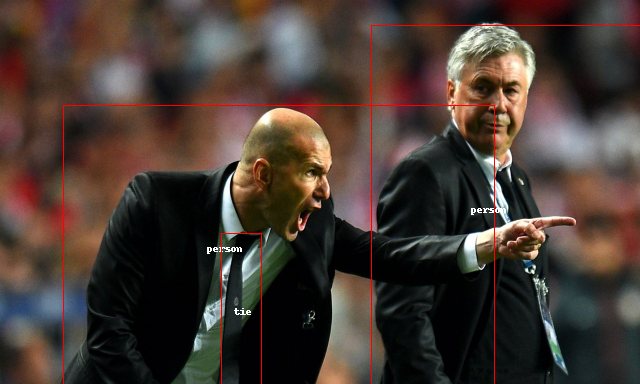

In [85]:
img_resized = resize(image=img)['image']
PIL_image = Image.fromarray(img_resized.astype('uint8'), 'RGB')
draw = ImageDraw.Draw(PIL_image)

for bboxes in nms_out[0]:
    box = bboxes[2:]
    class_idx = bboxes[0]
    x, y, w, h = tuple(box)
    draw.rectangle((x-(w/2), y-(h/2), x + w, y + h), outline="red", width=1)
    draw.text((x, y), labels[int(class_idx)], fill="white")

PIL_image

# Training the model on custom data

Now, as we already have the model defined, let us try to finetune it on a custom medical dataset.

Let us load the CPPE-5 dataset, which is a new challenging dataset with the goal to allow the study of subordinate categorization of medical personal protective equipments, which is not possible with other popular data sets that focus on broad level categories.

In [12]:
# ALADDIN'S MODIFIED
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint", GIoU=False, eps=1e-7):
    """
    Video explanation of this function:
    https://youtu.be/XXYG5ZWtjj0

    This function calculates intersection over union (iou) given pred boxes
    and target boxes.

    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)
        GIoU (bool): if True it computed GIoU loss (https://giou.stanford.edu)
        eps (float): for numerical stability

    Returns:
        tensor: Intersection over union for all examples
    """

    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    else:  # if not midpoints box coordinates are considered to be in coco format
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    w1, h1, w2, h2 = box1_x2 - box1_x1, box1_y2 - box1_y1, box2_x2 - box2_x1, box2_y2 - box2_y1
    # Intersection area
    inter = (torch.min(box1_x2, box2_x2) - torch.max(box1_x1, box2_x1)).clamp(0) * \
            (torch.min(box1_y2, box2_y2) - torch.max(box1_y1, box2_y1)).clamp(0)

    # Union Area
    union = w1 * h1 + w2 * h2 - inter + eps

    iou = inter / union

    if GIoU:
        cw = torch.max(box1_x2, box2_x2) - torch.min(box1_x1, box2_x1)  # convex (smallest enclosing box) width
        ch = torch.max(box1_y2, box2_y2) - torch.min(box1_y1, box2_y1)
        c_area = cw * ch + eps  # convex height
        return iou - (c_area - union) / c_area  # GIoU https://arxiv.org/pdf/1902.09630.pdf
    return iou  # IoU

Let us break down the loss into three primary components:

a. Class Loss (lcls)
The class loss (lcls) is calculated as the Binary Cross-Entropy (BCE) loss between the predicted class probabilities and the true class labels. This is computed only if there are multiple classes (self.nc > 1). The BCE loss quantifies the difference between the predicted class probabilities and the ground truth class labels.

b. Box Loss (lbox)
The box loss (lbox) represents the Localization Loss, measuring how well the predicted bounding boxes align with the ground truth bounding boxes. It's computed as the mean of (1.0 - IoU) loss, where IoU represents the Intersection over Union between predicted and true bounding boxes. A lower IoU indicates a higher box loss.

c. Objectness Loss (lobj)
The objectness loss (lobj) quantifies how well the model distinguishes objects from background. It's calculated as the BCE loss between predicted objectness scores and IoU ratios. Objectness scores are high if there is an object in the grid cell, and IoU ratios indicate how well the predicted box overlaps with the ground truth box.

The method combines the three loss components (lcls, lbox, and lobj) and scales them using predefined hyperparameters. The loss is then multiplied by the batch size (bs) to provide a batch-wise total loss.

In [13]:
class ComputeLoss:
    sort_obj_iou = False
    def __init__(self, model, im_size=640):
        device = next(model.parameters()).device
        self.BCEcls = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1], device=device))
        self.BCEobj = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1], device=device))
        head = model.model[-1]

        self.lambda_class = 0.5 * (head.num_classes / 80 * 3 / head.num_detection_layers)
        self.lambda_obj = 1 * ((im_size / 640) ** 2 * 3 / head.num_detection_layers)
        self.lambda_box = 0.05 * (3 / head.num_detection_layers)

        self.anchor_t = 4.0

        self.balance = [4.0, 1.0, 0.4]  # explanation.. https://github.com/ultralytics/yolov5/issues/2026
        self.na = head.num_anchors
        self.nc = head.num_classes
        self.nl = head.num_detection_layers
        self.anchors = head.anchors.to(device)

    def __call__(self, p, targets, pred_size, batch_idx=None, epoch=None):                          
        targets = targets.to(p[0].device, non_blocking=True)
        self.device = p[0].device
                          
        lcls = torch.zeros(1, device=self.device)  # class loss
        lbox = torch.zeros(1, device=self.device)  # box loss
        lobj = torch.zeros(1, device=self.device)  # object loss
        tcls, tbox, indices, anchors = self.build_targets(p, targets)  # targets
        for i, pi in enumerate(p):  # layer index, layer predictions
            b, a, gj, gi = indices[i]  # image, anchor, gridy, gridx
            tobj = torch.zeros(pi.shape[:4], dtype=pi.dtype, device=self.device)  # target obj
            n = b.shape[0]  # number of targets
            if n:
                pi_new = pi[b, a, gj, gi]
                pxy, pwh, _, pcls = pi_new.split((2, 2, 1, self.nc), 1)  # target-subset of predictions
                pxy = pxy.sigmoid() * 2 - 0.5
                pwh = (pwh.sigmoid() * 2) ** 2 * anchors[i]
                pbox = torch.cat((pxy, pwh), 1)  # predicted box
                iou = intersection_over_union(pbox, tbox[i], GIoU=True).squeeze()  # iou(prediction, target)
                lbox += (1.0 - iou).mean()  # iou loss
                iou = iou.detach().clamp(0).type(tobj.dtype)
                tobj[b, a, gj, gi] = iou  # iou ratio

                if self.nc > 1:  # cls loss (only if multiple classes)
                    t = torch.zeros_like(pcls, device=self.device)  # targets
                    t[range(n), tcls[i]] = 1
                    lcls += self.BCEcls(pcls, t)  # BCE

            obji = self.BCEobj(pi[..., 4], tobj)
            lobj += obji * self.balance[i]  # obj loss

        lbox *= self.lambda_box
        lobj *= self.lambda_obj
        lcls *= self.lambda_class
        bs = tobj.shape[0]  # batch size
        return (lbox + lobj + lcls) * bs

    def build_targets(self, p, targets):
        na, nt = self.na, targets.shape[0]  # number of anchors (x scale), targets
        tcls, tbox, indices, anch = [], [], [], []
        gain = torch.ones(7, device=self.device)  # normalized to grid_space gain

        ai = torch.arange(na, device=self.device).float().view(na, 1).repeat(1, nt)  # same as .repeat_interleave(nt)
        targets = torch.cat((targets.repeat(na, 1, 1), ai[..., None]), 2)  # append anchor indices
        g = 0.5  # bias
        off = torch.tensor(
            [
                [0, 0],
                [1, 0],
                [0, 1],
                [-1, 0],
                [0, -1],  # j,k,l,m
            ],
            device=self.device).float() * g  # offsets

        for i in range(self.nl):
            anchors, shape = self.anchors[i], p[i].shape
            gain[2:6] = torch.tensor(shape)[[3, 2, 3, 2]]  # xyxy gain
            t = targets * gain  # shape(3,n,7)
            if nt:
                r = t[..., 4:6] / anchors[:, None]  # wh ratio
                j = torch.max(r, 1 / r).max(2)[0] < self.anchor_t  # compare
                t = t[j]  # filter
                gxy = t[:, 2:4]  # grid xy

                gxi = gain[[2, 3]] - gxy  # inverse
                j, k = ((gxy % 1 < g) & (gxy > 1)).T
                l, m = ((gxi % 1 < g) & (gxi > 1)).T
                j = torch.stack((torch.ones_like(j), j, k, l, m))
                t = t.repeat((5, 1, 1))[j]
                offsets = (torch.zeros_like(gxy)[None] + off[:, None])[j]
            else:
                t = targets[0]
                offsets = 0
            bc, gxy, gwh, a = t.chunk(4, 1)  # (image, class), grid xy, grid wh, anchors
            a, (b, c) = a.long().view(-1), bc.long().T  # anchors, image, class
            gij = (gxy - offsets).long()
            gi, gj = gij.T  # grid indices
            indices.append((b, a, gj.clamp_(0, shape[2] - 1), gi.clamp_(0, shape[3] - 1)))  # image, anchor, grid
            tbox.append(torch.cat((gxy - gij, gwh), 1))  # box
            anch.append(anchors[a])  # anchors
            tcls.append(c)  # class
        return tcls, tbox, indices, anch

## Dataset

In [14]:
dataset = load_dataset("cppe-5", cache_dir="/archive/turganbay/.huggingface")

transform = albumentations.Compose([
    albumentations.Resize(640, 640),
    albumentations.VerticalFlip(p=0.3),
    albumentations.HorizontalFlip(p=1.0),
    albumentations.RandomBrightnessContrast(p=1.0),
], bbox_params=albumentations.BboxParams(format='coco', label_fields=["category"]))


categories = dataset["train"].features["objects"].feature["category"].names
id2label = {index: x for index, x in enumerate(categories, start=0)}
label2id = {v: k for k, v in id2label.items()}

Found cached dataset cppe-5 (/archive/turganbay/.huggingface/cppe-5/default/1.0.0/dd60c7c8210a67663b06108fb9e23c70acb98e2d3a4f3636f429509b19b74989)


  0%|          | 0/2 [00:00<?, ?it/s]

In [15]:
# we remove bad anotations from the train set
keep = [i for i in range(len(dataset["train"])) if i not in [590, 821, 822, 875, 876, 878, 879]]
dataset["train"] = dataset["train"].select(keep)

In [16]:
def coco_to_yolo_annotations(boxes, width, height, categories):
    annotations = []
    for box, category in zip(boxes, categories):
        x = (box[0] + box[2] / 2) / width
        y = (box[1] + box[3] / 2) / height
        #x = (box[0] * 2 + box[2]) / (2 * width)
        #y = (box[1] * 2 + box[3]) / (2 * height)
        w = box[2] / width
        h = box[3] / height
        annotations.append([category, x, y, w, h])
    annotations = torch.tensor(annotations)
    out_bboxes = torch.zeros((annotations.shape[0], 6))
    out_bboxes[..., 1:] = annotations
    return out_bboxes

In [18]:
class CPPE5Dataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        example = self.dataset[idx]
        image = np.array(example['image'].convert("RGB"))[:, :, ::-1]
        out = self.transform(
            image=image,
            bboxes=example['objects']['bbox'],
            category=example['objects']['category']
        )
        img_array = np.ascontiguousarray(np.array(out['image']).transpose((2, 0, 1)))
        img_tensor = torch.from_numpy(img_array) / 255
        out_bboxes = coco_to_yolo_annotations(out['bboxes'], img_array.shape[1], img_array.shape[2], out['category'])
        return img_tensor, out_bboxes  

In [19]:
def collate_fn_ultra(batch):
    im, label = zip(*batch)  # transposed
    for i, lb in enumerate(label):
        lb[:, 0] = i  # add target image index for build_targets()
    return torch.stack(im, 0), torch.cat(label, 0)

In [20]:
train_data = CPPE5Dataset(dataset['train'], transform=transform)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, num_workers=4, collate_fn=collate_fn_ultra)
test_data = CPPE5Dataset(dataset['test'], transform=transform)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False, num_workers=4, collate_fn=collate_fn_ultra)

img_batch, trg_batch = next(iter(train_loader))

## Training loop

To train a YOLO model, we need to provide it with a dataset of images and their corresponding annotations in the format of (img_id, class, cx, cy, w, h).

Since we already have a dataloader, we can start training the model by feeding it batches of images and annotations. At each training iteration, the model predicts bounding boxes and class probabilities for objects within the image and calculates the loss.

Common optimization algorithms such as stochastic gradient descent (SGD), Adam, or AdamW are applied to update the model's weights. The choice of optimizer depends on your specific dataset, model architecture, and training goals.

A learning rate scheduler dynamically adjusts the learning rate during training. YOLOv5 often employs a one-cycle learning rate policy, which involves gradually increasing and decreasing the learning rate. This approach can improve convergence and model performance.

Periodically, you save model checkpoints. These checkpoints serve as snapshots of your model's progress during training. They are useful for resuming training from a specific point or for performing inference on trained models later.

In [21]:
# change the head to the new with new num_classes
model.model[-1] = DetectionHead(num_classes=len(categories), anchors=default_anchors)

In [22]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=1e-4)
loss_fn = ComputeLoss(model)

grad_accum_steps = 8
num_train_epochs = 20
total_iters = len(train_loader) // grad_accum_steps * num_train_epochs
scheduler = transformers.get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=50, num_training_steps=total_iters
)

if torch.cuda.device_count() > 1:
    fast_rcnn = nn.DataParallel(fast_rcnn)

ckpt = torch.load("./yolo.pth.tar")
model.load_state_dict(ckpt['model_state_dict'])
model.to(device)

YoloModelSmall(
  (model): ModuleList(
    (0): ConvBNSiLU(
      (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): SiLU(inplace=True)
    )
    (1): ConvBNSiLU(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): SiLU(inplace=True)
    )
    (2): C3(
      (convBlock1): ConvBNSiLU(
        (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): SiLU(inplace=True)
      )
      (convBlock2): ConvBNSiLU(
        (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [23]:
def train_one_epoch(
    model, optimizer, train_loader, val_loader, device, epoch, num_epochs, grad_accum_steps=1, scheduler=None
):
    model.train()
    train_losses, val_losses = [], []

    # Training Phase
    for batch_idx, (images, targets) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch")):
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()  # Clear gradients from the previous batch

        logits = model(images)
        loss = loss_fn(logits, targets, pred_size=images.shape[2:4])
        loss.backward()

        # Gradient accumulation (if needed)
        if (batch_idx + 1) % grad_accum_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            if scheduler is not None:
                scheduler.step()

        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    print(f"Train Epoch {epoch + 1}/{num_epochs}, LR: {optimizer.param_groups[0]['lr']:.6f}, Loss: {train_loss:.3f}")

    # Release GPU memory
    del images, targets, loss
    torch.cuda.empty_cache()

    # Validation Phase
    model.eval()
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(val_loader):
            images, targets = images.to(device), targets.to(device)

            logits = model(images)
            loss = loss_fn(logits, targets, pred_size=images.shape[2:4])
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    print(f"Validation Loss: {val_loss:.3f}")

    return train_loss, val_loss


In [ ]:
best_val_loss = min(float("inf"), ckpt['val_loss'])
save_path = "./yolo.pth.tar"

for epoch in range(num_train_epochs):
    train_loss, val_loss = train_one_epoch(model, optimizer, train_loader, test_loader, device, epoch, num_train_epochs, grad_accum_steps, scheduler)
    if val_loss < best_val_loss and best_val_loss != float("-inf"):
        print(f"Saving...\nImproved on val_loss from {best_val_loss} to {val_loss}")
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss,
            'val_loss': val_loss,
            }, save_path)
    elif best_val_loss == float("inf"):
        best_val_loss = val_loss

## Inference on CPPE-5 medical dataset

In [61]:
model.eval()
torch.cuda.empty_cache()

In [64]:
img = dataset['test'][5]['image']
objs = dataset['test'][5]['objects']
resize = albumentations.Resize(640, 640)
img_resized = resize(image=np.array(img))['image']
transformed = np.ascontiguousarray(np.array(img_resized).transpose((2, 0, 1)))  # stack and BHWC to BCHW
transformed = torch.from_numpy(transformed) / 255 # normalization

out = model(transformed.unsqueeze(0).to(device))
nms_out = non_max_suppression(out, threshold=0.1)

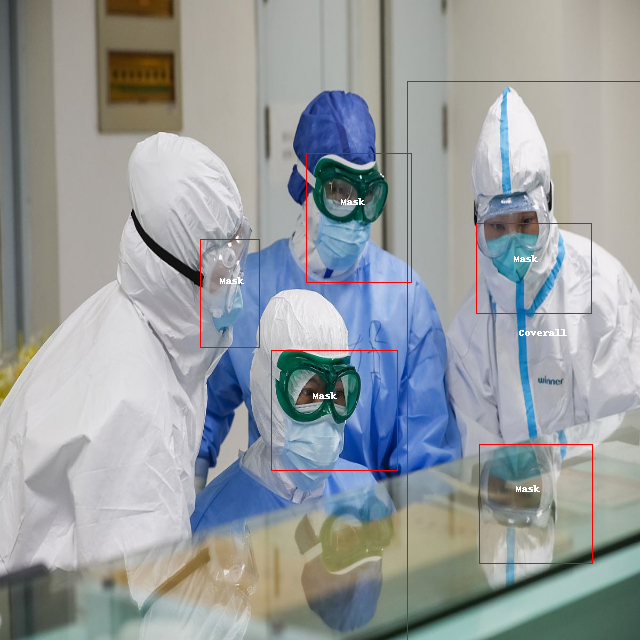

In [65]:
PIL_image = Image.fromarray(img_resized.astype('uint8'), 'RGB')
draw = ImageDraw.Draw(PIL_image)

for bboxes in nms_out[0]:
    box = bboxes[2:]
    class_idx = bboxes[0]
    x, y, w, h = tuple(box)
    draw.rectangle((x-(w/2), y-(h/2), x + w, y + h), outline="red", width=1)
    draw.text((x, y), id2label[int(class_idx)], fill="white")

PIL_image